In [1]:
%%html
<style>@font-face{font-family:myFont;src:url(v.ttf)}div.text_cell{font-family:myFont;direction:rtl;text-align:center;}</style>

# «به نام خدا»
## هوش مصنوعی 
## تمرین کامپیوتری شماره یک
## الگوریتم های سرچ
### امیرحسین دبیری اقدم - 810098024
### استاد: دکتر فدایی
#####  دانشگاه تهران - پاییز 99
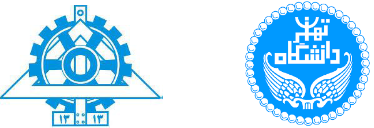
***

###  هدف پروژه : یافتن پاسخ اپتیمال برای بازی Snake با کمک الگوریتمهای جستجو مختلف 


### مقدمه:
<p style="text-align: right;">&nbsp;در این پروژه با به کارگیری الگوریتمهای مختلف سرچ (آگاهانه و ناآگاهانه) مسیر&nbsp; اپتمیال در مسئله داده شده را بدست خواهیم آورد و این الگورتیمها و ویژگیهای مختلف آنها را با هم مقایسه خواهیم کرد.</p>


<p style="text-align: right;"><strong>کلیت مسئله</strong>: این مسئله مشابه بازی Snake&nbsp; است با این تفاوت که در اینجا مکان دانه ها از قبل مشخص است و وظیفه ما بدست آوردن کوتاهترین مسیر برای خوردن همه دانه هاست بدون اینکه سر مار با بدنش برخورد کند.</p>
<p style="text-align: right;"><strong>مدلسازی مسئله</strong><strong>:</strong></p>
<p style="text-align: right;">هر State در این مسئله را با محل مار (به صورتtuple  ای از  tupleها به صورت زوج مرتب(x,y) ) و محل دانه ها در صفحه بازی (به صورتtuple  ای از tupleها به فرم(x,y),score) ) و نیز اینکه مار در این حرکت دانه ای را خورده یا خیر و در حرکت بعدی باید رشد کند یا خیر مدل میکنیم.  </p>
<p style="text-align: right;">به این ترتیب Initial State حالتی است که مار در محل اولیه اش قرار دارد و طول آن برابر یک است و دانه ها با امتیاز اولیه شان در جای خود در صفحه بازی قرار دارند که این اطلاعات از فایل مربوط به هر تست کیس بدست می آید؛ Goal State حالتی است که هیچ دانه ای در صفحه بازی برای خوردن نمانده باشد.</p>
<p style="text-align: right;">Action در این بازی هر حرکت مار در جهتهای بالا،راست،پایین و چپ است و هزینه همه این حرکتها برابر یک است. اگر در نتیجه یکی از این حرکات سر مار درخانه ای که دانه قرار دارد قرار بگیرد یکی از امتیاز آن دانه کم شده و در صورتی که امتیاز آن صفر شود به طور کامل از صفحه بازی حذف خواهد شد.</p>
<p style="text-align: right;">Path Cost <span>تعداد </span>Action های انجام گرفته تا رسیدن به هر حالت است.</p>
<p style="text-align: right;">همچنین برای نگه داشتن رویه کلی سرچ گراف از یک کلاس Node که شامل State,Cost,Parent,Action برای هر node است استفاده شده است. همچنین برای الگوریتم A* نیازمند نگهداری مقدار f(n) برای هر node داریم که در بخش مربوطه توضیح داده شده است.</p>
<p style="text-align: right;">یک کلاس Problem برای نگهداری Initial State هر تست کیس و ابعاد صفحه بازی نیز تعریف شده است.</p>

<p style="text-align: right;"> با توصیفات گفته شده کلاسها و توابع مورد نیاز (به همراه توضیح کلی در هرکدام) برای پیاده سازی هر سرچ در ادامه آمده است:</p>

In [2]:
#importing libraries
import time

In [3]:
#defining classes
class Node:
    def __init__(self, s, c = 0, h = 0, p = None, a = None):
        self.state = s
        self.cost = c
        self.f = c + h # cost + heuristic
        self.parent = p
        self.action = a
    
    def __eq__(self, other):
        return self.state == other.state
    
    def __hash__(self):
        return hash(self.state)

class Problem:
     def __init__(self, x, y, i):
        self.maxX = x - 1
        self.maxY = y - 1
        self.initstate = i #tuple

class State:
    def __init__(self, s, f, g = False):
        self.snake = s #tuple of tuples
        self.foods = f #tuple of tuples
        self.grow = g  #bool
    
    def __eq__(self, other):
        return self.snake == other.snake and self.grow == other.grow

    def __hash__(self):
        return hash((self.snake,self.grow))

In [4]:
#helper functions
def str_list_to_int_list(str_list): 
    int_list = list(map(int,str_list))
    return int_list

In [5]:
#function to generate a problem from files provided alongside the notebook.
def createProblem(name):
    file = open(name, "r")
    lines = [line.rstrip('\n') for line in file]
    map_dimensions = str_list_to_int_list(lines[0].split(','))
    init_state = str_list_to_int_list(lines[1].split(','))
    foods_count = int(lines[2])
    foods = list()
    for i in range(0, foods_count):
        line_data = str_list_to_int_list(lines[3 + i].split(','))
        foods.append(((line_data[0], line_data[1]), line_data[2]))

    s = tuple([tuple(init_state)])
    st = State(s, tuple(foods))
    p = Problem(map_dimensions[0], map_dimensions[1], st)
    return p

In [6]:
#generate problems from given files
problems = list()
for i in [1,2,3]:
    problems.append(createProblem("test%d.txt" % (i)))

In [7]:
#function to print solution and related infos
def solution(node, explored = set(), stateCount = 0):
    ans = ""
    print("Path cost: %d - All States: %d - Unique States: %d" %(node.cost, stateCount ,len(explored)))
    while (node.parent):
        ans += node.action
        node = node.parent
    return ans[::-1]

In [8]:
#function to test if goal State reached, i.e., no more foods left on the map.
def goalTest(state):
    return (len(state.foods) == 0)

In [9]:
#function to generate available Actions for any state in state space.
def availableActions(problem, state):
    actions = list()
    body = state.snake
    (headX, headY) = body[-1]
    if (len(body) > 2 and state.grow == False): body = body[1:]

    newHeadU = (headX - 1, headY)
    newHeadR = (headX, headY + 1)
    newHeadD = (headX + 1, headY)
    newHeadL = (headX, headY - 1)
    if (headX - 1 < 0):
        newHeadU = (problem.maxX, headY)
    if (headY + 1 > problem.maxY):
        newHeadR = (headX, 0)
    if (headX + 1 > problem.maxX):
        newHeadD = (0, headY)
    if (headY - 1 < 0):
        newHeadL = (headX, problem.maxY)

    if (newHeadU not in body): actions.append("U")
    if (newHeadR not in body): actions.append("R")
    if (newHeadD not in body): actions.append("D")
    if (newHeadL not in body): actions.append("L")

    return actions

In [10]:
#function to generate child node for any given parent node and action.
#it was possible to break it to some more readable small functions but this way it is more efficient.
def childNode(problem, parent, action, heuristic = lambda x:0):
    currentState = parent.state
    body = currentState.snake
    (headX, headY) = body[-1]
    if (action == "U"):
        headX = headX - 1
        if (headX < 0): headX = problem.maxX
    elif (action == "R"):
        headY = headY + 1
        if (headY > problem.maxY): headY = 0
    elif (action == "D"):
        headX = headX + 1
        if (headX > problem.maxX): headX = 0
    elif (action == "L"):
        headY = headY - 1
        if (headY < 0): headY = problem.maxY
    
    newHead = (headX, headY)
    Grow = False
    foods = list(currentState.foods)
    for food in foods:
        if (food[0] == newHead):
            Grow = True
            foods.remove(food)
            if (food[1] > 1): foods.append((food[0], food[1] - 1))
            break
    if (currentState.grow == False):
        body = body[1:] 
    body += (newHead,)
    newState = State(body, tuple(foods), Grow)
    child = Node(newState, parent.cost + 1, heuristic(newState.foods), parent, action)
    return child

### الگوریتم  BFS 
<div class="tg-wrap">
<p style="text-align: right;">در این الگوریتم در هر مرحله کم عمق ترین نود بسط داده نشده در frontier را بسط میدهیم و فرزندان آنرا اگر تکراری نباشند به frontier &nbsp;اضافه میکنیم و البته برای همه آنها تست goal هم انجام میدهیم.برای این کار نیاز به یک لیست FIFO داریم که با استفاده از دستورات append() و pop(0) دیتا استراکچر لیست در پایتون این کار امکانپذیر است (برای افزایش سرعت الگوریتم ازیک ست هم استفاده کردیم تا سرعت چک کردن وجود نود ها در frontier افزایش پیدا کند)؛ همچنین برای اینکه حالات تکراری بسط داده نشود، state های بسط داده شده را در ست explored نگهداری می کنیم.</p>
<p style="text-align: right;">این الگوریتم Complete است و در این مسئله چون هزینه هر Action یکسان است جواب Optimal را هم میدهد.</p>
</div>

In [11]:
def BFS(problem):
    node = Node(problem.initstate)
    if (goalTest(node.state)): return solution(node, set(node), 1)
    frontier = list()
    frontier_set = set() #for speeding up the algorithm because searching in sets are way faster than lists (O(1) VS O(n))
    frontier.append(node)
    frontier_set.add(node)
    explored = set()
    stateCount = 1
    while(frontier):
        node = frontier.pop(0)
        frontier_set.remove(node)
        explored.add(node.state)
        for action in availableActions(problem, node.state):
            child = childNode(problem, node, action)
            stateCount += 1
            if (child.state not in explored and child not in frontier_set):
                if (goalTest(child.state)): return solution(child, explored, stateCount)
                frontier.append(child)
                frontier_set.add(child)
    return "Failed"

In [12]:
#testing
for i in range(3):
    tic = time.time()
    print(BFS(problems[i]))
    toc = time.time()
    print("%fs\n" %((toc - tic)))

Path cost: 12 - All States: 3935 - Unique States: 1311
DLUULULLUULL
0.021911s

Path cost: 15 - All States: 34998 - Unique States: 11962
URDLLUUUULULLLL
0.194532s

Path cost: 25 - All States: 61506 - Unique States: 21370
URRDDDRRDRRRDDRRULLDLUULL
0.400929s



### الگوریتم  IDS 
<div class="tg-wrap">
<p style="text-align: right;">در این الگوریتم &nbsp;تابع DLS که درواقع DFS با عمق محدود است را با محدودیت عمق صفر تا بینهایت صدا میزنیم؛ در الگوریتم DLS عمیق ترین نود بسط داده نشده در frontier را تا رسیدن به محدودیت داده شده بسط میدهیم ( درحالت کلی میتوان هر نود که انتخاب میشود را تست goal انجام داد اما اینجا چون الگوریتمIDS است چک کردن نودهایی که در آخرین عمق قرار دارند بهینه تر است) که برای این کار نیاز به یک لیست LIFO داریم که با استفاده از دستورات append() و pop() دیتا استراکچر لیست در پایتون این کار امکانپذیر است. وقتی به محدودیت داده شده رسیدیم دیگر ادامه نمیدهیم پس اگر عمق جواب از محدودیت داده شده توسط ما بیشتر باشد به جواب نمیرسیم به همین دلیل این تابع را با محدودیت عمق صفر تا بینهایت صدا میزنیم؛ به این ترتیب مشکل DFS که ممکن بود باعث شود در لوپ بینهایت قرار بگیریم را در اینجا نداریم و نیز حافظه کمتری نسبت به BFS اشغال میکند(زیرا اینجا به صورت خطی لازم است نودها ذخیره شوند ولی در BFS چون همه نودهای همه سطوح تا رسیدن به جواب نگهداری میشود به صورت نمایی است) و به نوعی میتوان گفت این الگوریتم ترکیب BFS و DFS میباشد.</p>
<p style="text-align: right;">&nbsp;این الگوریتم Complete است و در این مسئله چون هزینه هر Action یکسان است جواب Optimal را هم میدهد.</p>
</div>

In [13]:
def DLS(problem, limit = 0):
    node = Node(problem.initstate)
    frontier = list()
    frontier_set = set()
    frontier.append(node)
    frontier_set.add(node)
    explored = set()
    stateCount = 1
    while(frontier):
        node = frontier.pop()
        frontier_set.remove(node)
        if (node.cost == limit): 
            if (goalTest(node.state)): return solution(node, explored, -1)
            continue
        explored.add((node.state, node.cost))
        for action in availableActions(problem, node.state):
            child = childNode(problem, node, action)
            stateCount += 1
            if ((child.state, child.cost) not in explored and child not in frontier_set):
                frontier.append(child)
                frontier_set.add(child)
    return stateCount

In [14]:
def IDS(problem):
    depth = 0
    states = 0
    while(True):
        result = DLS(problem, depth)
        if (isinstance(result,str)): 
            print("All iterations states: %d" %(states))
            return result
        else: states+= result
        depth += 1 

In [15]:
#testing
for i in range(3):
    tic = time.time()
    print(IDS(problems[i]))
    toc = time.time()
    print("%fs\n" %((toc - tic)))

Path cost: 12 - All States: -1 - Unique States: 2582
All iterations states: 19210
LDLUULULLLUU
0.227382s

Path cost: 15 - All States: -1 - Unique States: 15848
All iterations states: 198570
LRRULLLUUULLLLU
1.436172s

Path cost: 25 - All States: -1 - Unique States: 56046
All iterations states: 674695
RUDDDRDRRDDRRRRRULLDLLLUU
4.461295s



### الگوریتم  A* 
<div class="tg-wrap">
<p style="text-align: right;">در این الگوریتم از میان اعضای frontier نودی که کمترین مقدار f را دارد برای بسط دادن انتخاب میشود (f = cost + heuristic) و فرزندان آنرا اگر تکراری نباشند به frontier &nbsp;اضافه میکنیم اما برخلاف BFS در اینجا فقط وقتی یک نود برای بسط داده شدن انتخاب میشود تست goal برای آن انجام میگیرد نه وقتی که به frontier &nbsp;اضافه میشود.مشابه قبل با استفاده از list و set به سادگی میتوان این الگوریتم را پیاده کرد.</p>
<p style="text-align: right;">این الگوریتم Complete است و در این مسئله که سرچ گراف است چون heuristic های پیشنهادی ما consistent هستند جواب Optimal را هم میدهد.</p>
</div>

<p style="text-align: right;">اگر به صورت خیلی ساده شده به مسئله نگاه کنیم و فرض کنیم دانه ها &nbsp;در خانه های پشت سرهم قرار گرفته اند حداقل به تعداد خانه هایی که هنوز در آنها دانه وجود دارد حرکت تا رسیدن به goal داریم پس یکی از heuristic ها را " تعداد خانه هایی که هنوز در آنها دانه وجود دارد" در نظر میگیریم و این heuristic هم admissible است و هم consistent.</p>
<p style="text-align: right;">اگر دقیق تر به مسئله نگاه کنیم چون ممکن است در بعضی خانه ها دانه هایی دو امتیازی داشته باشیم پس یکبار عبور از آنها کافی نیست پس اگر خیلی ساده در نظر بگیریم حداقل به تعداد مجموع امتیاز دانه هایی که در صفحه بازی قراردارند Action تا رسیدن به goal داریم پس heuristic دوم را " مجموع امتیاز دانه هایی که در صفحه بازی قراردارند " در نظر میگیریم که این هم مشابه قبلی consistent و در نتیجه admissible است.</p>
<p style="text-align: right;">heuristic دوم نسبت به اولی تخمین بهتری است و به مقدار واقعی نزدیک تر است و انتظار داریم زودتر مارا به جواب اپتیمال برساند. (البته ممکن است روش محاسبه آن کمی باعث کند شدن آن شود زیرا باید یک لوپ روی دانه های باقیمانده روی صفحه بزند)</p>
<p style="text-align: right;">همچنین برای الگوریتم weighted A* از heuristic دوم &nbsp;استفاده میکنیم و یکبار مقدار آلفا را 1.95 و بار دیگر 4.95 قرارمیدهیم.</p>

In [16]:
#heuristics used in A*
def h1(foods):
    return len(foods)

def h2(foods):
    return sum([f[1] for f in foods])

#heuristics used in weighted A*
def h2_2(foods):
    return 1.95 * sum([f[1] for f in foods])

def h2_5(foods):
    return 4.95 * sum([f[1] for f in foods])

In [17]:
def ASTAR(problem, heuristic = h1): 
    node = Node(problem.initstate)
    frontier = list() 
    frontier_set = set()
    frontier.append(node)
    frontier_set.add(node)
    explored = set()
    stateCount = 1
    while(frontier):
        node = frontier.pop(0)
        frontier_set.remove(node)
        if (goalTest(node.state)): return solution(node, explored, stateCount)
        explored.add(node.state)
        for action in availableActions(problem, node.state): 
            child = childNode(problem, node, action, heuristic)
            stateCount += 1
            if (child.state not in explored and child not in frontier_set):
                i = 0
                f_n = child.f 
                l = len(frontier)
                while (i < l and frontier[i].f < f_n):
                    i += 1
                frontier.insert(i, child) 
                frontier_set.add(child)
            elif (child in frontier_set):
                i = frontier.index(child) 
                if (frontier[i].cost > child.cost):  frontier[i].cost = child.cost   
    return "Failed"


In [18]:
#testing
print("heuristic 1")
for i in range(3):
    tic = time.time()
    print(ASTAR(problems[i], h1))
    toc = time.time()
    print("%fs\n" %((toc - tic)))
    
print("heuristic 2")
for i in range(3):
    tic = time.time()
    print(ASTAR(problems[i], h2))
    toc = time.time()
    print("%fs\n" %((toc - tic)))
    
print("heuristic 2 with alpha = 1.95")
for i in range(3):
    tic = time.time()
    print(ASTAR(problems[i], h2_2))
    toc = time.time()
    print("%fs\n" %((toc - tic)))

print("heuristic 2 with alpha = 4.95")
for i in range(3):
    tic = time.time()
    print(ASTAR(problems[i], h2_5))
    toc = time.time()
    print("%fs\n" %((toc - tic)))

heuristic 1
Path cost: 12 - All States: 3796 - Unique States: 1265
LDUULLULLULU
0.189485s

Path cost: 15 - All States: 26338 - Unique States: 8987
URDLLUUUULULLLL
4.416197s

Path cost: 25 - All States: 49455 - Unique States: 17119
RUDDRDRRDRDDRRURRDLLLLULU
8.134777s

heuristic 2
Path cost: 12 - All States: 2175 - Unique States: 722
LDUULLULLULU
0.062840s

Path cost: 15 - All States: 26338 - Unique States: 8987
URDLLUUUULULLLL
4.393401s

Path cost: 25 - All States: 39395 - Unique States: 13566
RUDDRDRRDRRDDRURRDLLLLULU
5.713569s

heuristic 2 with alpha = 1.95
Path cost: 12 - All States: 1466 - Unique States: 487
LDDDRRRDRRDD
0.043873s

Path cost: 15 - All States: 18781 - Unique States: 6468
RULDLUUULUULLLL
4.476492s

Path cost: 25 - All States: 32135 - Unique States: 11038
RUDDRDRRDRRDDRURRDLLLLULU
7.984756s

heuristic 2 with alpha = 4.95
Path cost: 12 - All States: 74 - Unique States: 24
LDULULULLULU
0.001025s

Path cost: 17 - All States: 3641 - Unique States: 1282
LURRDLLUUUULULLLL
0.

<h4 style="text-align: right;">در ادامه جدول نتایج الگوریتمهای مختلف برای هر تست آمده است:</h4>

#### نتایج تست 1
<div class="tg-wrap">
<table class="tg" style="direction: ltr; border-collapse: collapse; border-color: #9ABAD9; border-spacing: 0; margin: 0px auto;">
<thead>
<tr>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">&nbsp;الگوریتم</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">فاصله جواب</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">مسیر جواب</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">تعداد کل استیت&nbsp;</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">تعداد استیت مجزای دیده شده</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">زمان اجرا</th>
</tr>
</thead>
<tbody>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">BFS</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">12</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">DLUULULLUULL</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">3935</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">1311</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.0575645s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">IDS</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">12</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LDLUULULLLUU</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">19210</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">2582</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.203341s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">A* - heuristic 1</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">12</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LDUULLULLULU</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">3796</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">1265</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.1681555s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">A* - heuristic 2</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">12</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LDUULLULLULU</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">2175</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">722</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.0689955s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">Weighted A* - heuristic2 - apha = 1.95</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">12</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LDDDRRRDRRDD</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">1466</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">487</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.0678315s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">Weighted A* - heuristic2 - alpha = 4.95</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">12</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LDULULULLULU</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">&nbsp;74&nbsp;</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">&nbsp;24</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.0017615s</td>
</tr>
</tbody>
</table>
</div>

#### نتایج تست 2
<div class="tg-wrap">
<table class="tg" style="direction: ltr; border-collapse: collapse; border-color: #9ABAD9; border-spacing: 0; margin: 0px auto;">
<thead>
<tr>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">&nbsp;الگوریتم</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">فاصله جواب</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">مسیر جواب</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">تعداد کل استیت&nbsp;</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">تعداد استیت مجزای دیده شده</th>
<th style="background-color: #409cff; color: #ffffff; font-family: myFont; font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">زمان اجرا</th>
</tr>
</thead>
<tbody>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">BFS</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">15</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">URDLLUUUULULLLL</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">34998</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">11962</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.2561765s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">IDS</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">15</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LRRULLLUUULLLLU</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">198570</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">15848</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">1.4613215s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">A* - heuristic 1</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">15</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">URDLLUUUULULLLL</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">26338</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">8987</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">4.06541s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">A* - heuristic 2</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">15</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">URDLLUUUULULLLL</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">26338</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">8987</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">4.045354s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">Weighted A* - heuristic2 - apha = 1.95</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">15</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">RULDLUUULUULLLL</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">18781</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">6468</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">4.750866s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">Weighted A* - heuristic2 - alpha = 4.95</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">17</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">LURRDLLUUUULULLLL</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">3641</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">1282</td>
<td style="background-color: #ebf5ff; color: #444444; font-family: myFont; font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.2629265s</td>
</tr>
</tbody>
</table>
</div>

#### نتایج تست 3
<div class="tg-wrap">
<table class="tg" style="direction: ltr; border-collapse: collapse; border-color: #9ABAD9; border-spacing: 0; margin: 0px auto;">
<thead>
<tr>
<th style="background-color: #409cff; color: #ffffff;  font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">&nbsp;الگوریتم</th>
<th style="background-color: #409cff; color: #ffffff;  font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">فاصله جواب</th>
<th style="background-color: #409cff; color: #ffffff;  font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">مسیر جواب</th>
<th style="background-color: #409cff; color: #ffffff;  font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">تعداد کل استیت&nbsp;</th>
<th style="background-color: #409cff; color: #ffffff;  font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">تعداد استیت مجزای دیده شده</th>
<th style="background-color: #409cff; color: #ffffff;  font-size: 14px; font-weight: normal; overflow: hidden; padding: 10px 5px; position: sticky; top: -1px; vertical-align: top; will-change: transform; word-break: normal; text-align: center;">زمان اجرا</th>
</tr>
</thead>
<tbody>
<tr>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">BFS</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">25</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">URRDDDRRDRRRDDRRULLDLUULL</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">61506</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">21370</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.3948595s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">IDS</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">25</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">RUDDDRDRRDDRRRRRULLDLLLUU</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">674695</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">56046</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">4.6710365s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">A* - heuristic 1</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">25</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">RUDDRDRRDRDDRRURRDLLLLULU</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">49455</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">17119</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">8.126135s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">A* - heuristic 2</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">25</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">RUDDRDRRDRRDDRURRDLLLLULU</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">39395</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">13566</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">7.300002s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">Weighted A* - heuristic2 - apha = 1.95</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">25</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">RUDDRDRRDRRDDRURRDLLLLULU</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">32135</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">11038</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">8.2271565s</td>
</tr>
<tr>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">Weighted A* - heuristic2 - alpha = 4.95</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">26</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">RUDDDRRDRRULDDDRRRRURULLDD</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">998</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">349</td>
<td style="background-color: #ebf5ff; color: #444444;  font-size: 14px; overflow: hidden; padding: 10px 5px; vertical-align: top; word-break: normal; text-align: center;">0.012981s</td>
</tr>
</tbody>
</table>
</div>

<p style="text-align: right;"><strong>مقایسه الگوریتم ها:</strong></p>
<p style="text-align: right;">همانطور که گفتیم همه الگوریتم ها کامل هستند و جواب اپتیمال را هم میدهند (به جز کهweighted A* که اپتیمال نیست) ؛ پس تفاوت آنها در سرعت و مقدار استفاده از حافظه است.</p>
<p style="text-align: right;">مزیت IDS نسبت به BFS حافظه کمتری است که اشغال میکند اما در مقابل به دلیل اینکه یک سری استیت هارا به چندین بار چک میکند سرعت کمتری دارد و BFS خیلی سرعت بالایی دارد و از همه الگوریتم ها (به جز weighted A*) سریعتر عمل میکند که البته یک علت آن این است که توابع دیگر را کمتر صدا میزند (مثلا A* به دلیل اینکه توابع دیگر را به صورت مکرر فراخوانی میکند برای محاسبه f و... همچنین چون پیدا کردن نود با کمترین f نیز زمانبر است در اینجا کندتر از BFS است اما تعداد استیت هایی که در A* بررسی میشود کمتر از BFS است و از این نظر به آن ارجحیت دارد)</p>
<p style="text-align: right;">پس به طور کلی میتوان گفت برای بدست آوردن حالت اپتیمال، از نظر سرعت و حافظه IDS تعادل خوبی (استفاده خطی از حافظه در مقابل استفاده نمایی در BFS و A*) دارد اما اگر سرعت برای ما در اولویت اول است استفاده از BFS بهتر خواهد بود. (البته به صورت جنرال A* گزینه بهتری از نظر سرعت است اما به دلایل گفته شده در اینجا BFS از آن سریعتر است)</p>
<p style="text-align: right;">اگر اپتیمال بودن اهمیت نداشته باشد استفاده از weighted A* از نظر سرعت و همچنین حافظه بهترین انتخاب است که البته باید با تنظیم آلفا بین سرعت و نزدیک بودن به حالت اپتیمال، تعادل ایجاد کرد.</p>
<p style="text-align: right;">الگوریتم weighted A* با مقدار آلفای حدود 5 با توجه به اینکه دیگر admissible نیست و تخمینی که میزند بیشتر از مقدار واقعی است &nbsp;بهینه ترین جواب را نمیدهد اما بسیار به جواب بهینه نزدیک است و در مقابل بسیار بسیار سریع عمل میکند زیرا تعداد نود بسیار کمتری را بسط میدهد.</p>
<p style="text-align: right;">وقتی مقدار آلفا 2 است فاصله تخمینی از مقدار واقعی همچنان کمتر است و admissible و است و جواب اپتیمال را میدهد و چون به مقدار واقعی نزدیک تر است و استیت های کمتری را میبیند نسبت به حالت آلفا برابر 1 و انتظار داریم سریعتر از آن باشد اما اینطور نیست و حتی اندکی کندتر میشود که احتمالا علت آن این است که ضرب دو عدد که یکی از آنها اعشاری است overhead زیادی دارد و در کل تاثیر آن بیشتر از &nbsp;تاثر کمتر بودن تعداد استیت هاست و در کل کمی الگوریتم کندتر میشود!</p>